## Vorgehen

### Datenaufbereitung Kaggle
- Entferne alle Brands die unter 1000 mal auftreten
- Entferne alle User die unter 10 mal auftreten und bei Usern mit mehr, entferne alle Einträge die "zu viel" sind  
 **Resultat:** Dataframe in welchem jeder User genau 10 mal auftritt. Verwende 9 zum encoden und 1 zum predicten

### Vorgehen Jupyter Notebook
- Erstelle Timeseries Datensatz aus Dataframe, erstelle TFT, Dataloaders
- Trainiere TFT
- Erhalte Importances durch weglassen. Wichtig ist predict_mode=True, sonst werden unterschiedliche viele zum encoden verwendet.  
 **Problem:** Es wird nur noch 0 immer predicted, egal was man macht, egal welchen Dataframe man wählt. Habe es auch mit df_custom.csv und df_10.csv probiert. 
 
### Ausblick
- Problem mit 0 predictions fixen
- Eventuell gleichmäßigere Verteilung über Clicks hinbekommen, siehe Histogramm. Aber wie?
- Explainer von unten verwenden um Spaltenwert für Brand zu erhalten und das dann runterrechnen auf Importances
- Statistische Evidenz finden, dass die Importances die rauskommen nicht rein zufällig sind

In [1000]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, CrossEntropy
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split


In [1001]:
import warnings
warnings.filterwarnings('ignore')


In [1002]:
df = pd.read_csv("df_updated.csv")
df.rename(columns={"clk": "click"},inplace=True)

In [1003]:
#df = df[:200]

In [1004]:
#adgroup_id cate_id price ändern sich doch -> entfernen
#Alles zu ints casten, damit Häufigkeiten betrachtet werden können
df.drop(columns=["adgroup_id","cate_id","price"],inplace=True)
df['click'] = df['click'].astype(int)
df['final_gender_code'] = df['final_gender_code'].astype(int)
df['age_level'] = df['age_level'].astype(int)
df['shopping_level'] = df['shopping_level'].astype(int)
df['occupation'] = df['occupation'].astype(int)

In [1005]:
df

,user,time_stamp,click,brand,final_gender_code,age_level,shopping_level,occupation,time_idx
0,7,2017-05-07 07:44:12,0,402360.0,1,2,3,0,0
1,7,2017-05-07 07:46:36,0,429159.0,1,2,3,0,1
2,7,2017-05-07 23:15:38,0,402360.0,1,2,3,0,2
3,7,2017-05-07 23:16:54,0,252916.0,1,2,3,0,3
4,7,2017-05-08 02:16:42,0,429159.0,1,2,3,0,4
...,...,...,...,...,...,...,...,...,...
292545,1141697,2017-05-12 21:22:11,1,402360.0,1,4,2,0,5
292546,1141697,2017-05-12 22:38:15,0,98931.0,1,4,2,0,6
292547,1141697,2017-05-12 22:38:15,0,144770.0,1,4,2,0,7
292548,1141697,2017-05-12 23:10:27,0,216655.0,1,4,2,0,8


In [1006]:
len(df.user.unique())

29255

In [1007]:
#Betrachte wie die Merkmale aufgeteilt sind bezüglich Clicks
df.groupby('brand')['click'].sum().sum()/(len(df))

0.04728422491881729

In [1008]:
len(df)

292550

In [1009]:
df.groupby('age_level')['click'].sum()

age_level
0       2
1     713
2    2262
3    4174
4    3648
5    2794
6     240
Name: click, dtype: int64

In [1010]:
df.groupby('shopping_level')['click'].sum()

shopping_level
1      583
2     1192
3    12058
Name: click, dtype: int64

In [1011]:
df.groupby('final_gender_code')['click'].sum()

final_gender_code
1     2969
2    10864
Name: click, dtype: int64

In [1012]:
df.groupby('occupation')['click'].sum()

occupation
0    13161
1      672
Name: click, dtype: int64

In [1013]:
#Alles wieder zurück zu kategorischen Variablen casten, damit es im Timeseries Dataset verwendet werden kann
df['age_level'] = df['age_level'].astype(str)
df['final_gender_code'] = df['final_gender_code'].astype(str)
df['shopping_level'] = df['shopping_level'].astype(str)
df['occupation'] = df['occupation'].astype(str)
df['brand'] = df['brand'].astype(int).astype(str)
df['click'] = df['click'].astype(str)

In [1014]:
#Zähle wie oft welche Brand geklickt worden ist um Ranking bilden zu können. _relative teilt durch Häufigkeit der Brand
df['click'] = df['click'].astype(int)
click_counts = df.groupby('brand')['click'].sum().sort_values(ascending=False)
click_counts_relative = (df.groupby('brand')['click'].sum().sort_index() / df['brand'].value_counts().sort_index()).sort_values(ascending=False)
df['click'] = df['click'].astype(str)

In [1016]:
len(df)*0.1

29255.0

In [1017]:
df_test = df[:int(len(df)*0.1)]
df.drop(df_test.index,inplace=True)

In [1018]:
#df = df.head(1000)

In [1019]:

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 10],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=9,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=9,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level","final_gender_code","shopping_level","occupation"],
    #static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [1020]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

In [1028]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    
    
    #TODO: Loss ändern
    loss=CrossEntropy(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    enable_model_summary=True,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    max_epochs=20,
    logger = logger,
    callbacks=[lr_logger, early_stop_callback],
)

# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | CrossEntropy                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 4.0 K 
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 626   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 904   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 814   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNet

Number of parameters in network: 10.1k
Epoch 0: 100%|█| 205/205 [00:21<00:00,  9.61it/s, v_num=6, train_loss_step=0.093
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  45%|███████▋         | 93/206 [00:06<00:08, 13.69it/s]


Validation DataLoader 0:  92%|██████████████▊ | 190/206 [00:13<00:01, 13.76it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:14<00:00, 13.72it/s]
Epoch 0: 100%|█| 205/205 [00:36<00:00,  5.63it/s, v_num=6, train_loss_step=0.093
Epoch 1: 100%|█| 205/205 [00:20<00:00, 10.08it/s, v_num=6, train_loss_step=0.164
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  38%|██████▍          | 78/206 [00:05<00:09, 13.98it/s]


Validation DataLoader 0:  85%|█████████████▌  | 175/206 [00:12<00:02, 13.61it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:15<00:00, 13.64it/s]
Epoch 1: 100%|█| 205/205 [00:35<00:00,  5.77it/s, v_num=6, train_loss_step=0.164
Epoch 2: 100%|█| 205/205 [00:20<00:00, 10.21it/s, v_num=6, train_loss_step=0.213
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  31%|█████▏           | 63/206 [00:04<00:10, 13.38it/s]


Validation DataLoader 0:  78%|████████████▍   | 160/206 [00:12<00:03, 12.60it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:16<00:00, 12.52it/s]
Epoch 2: 100%|█| 205/205 [00:36<00:00,  5.60it/s, v_num=6, train_loss_step=0.213
Epoch 3: 100%|█| 205/205 [00:22<00:00,  9.31it/s, v_num=6, train_loss_step=0.182
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  23%|███▉             | 48/206 [00:03<00:12, 12.66it/s]


Validation DataLoader 0:  70%|███████████▎    | 145/206 [00:11<00:04, 12.40it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:16<00:00, 12.50it/s]
Epoch 3: 100%|█| 205/205 [00:38<00:00,  5.32it/s, v_num=6, train_loss_step=0.182
Epoch 4: 100%|█| 205/205 [00:22<00:00,  9.19it/s, v_num=6, train_loss_step=0.242
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  16%|██▋              | 33/206 [00:02<00:12, 14.08it/s]


Validation DataLoader 0:  63%|██████████      | 130/206 [00:09<00:05, 13.48it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:16<00:00, 12.77it/s]
Epoch 4: 100%|█| 205/205 [00:38<00:00,  5.33it/s, v_num=6, train_loss_step=0.242
Epoch 5: 100%|█| 205/205 [00:23<00:00,  8.70it/s, v_num=6, train_loss_step=0.138
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   9%|█▍               | 18/206 [00:01<00:12, 14.50it/s]


Validation DataLoader 0:  56%|████████▉       | 115/206 [00:11<00:09, 10.06it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:21<00:00,  9.45it/s]
Epoch 5: 100%|█| 205/205 [00:45<00:00,  4.51it/s, v_num=6, train_loss_step=0.138
Epoch 6: 100%|█| 205/205 [00:24<00:00,  8.43it/s, v_num=6, train_loss_step=0.157
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   1%|▎                 | 3/206 [00:00<00:14, 14.43it/s]


Validation DataLoader 0:  49%|███████▊        | 100/206 [00:07<00:08, 12.82it/s]


Validation DataLoader 0:  96%|███████████████▎| 197/206 [00:15<00:00, 12.81it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:15<00:00, 12.82it/s]
Epoch 6: 100%|█| 205/205 [00:40<00:00,  5.07it/s, v_num=6, train_loss_step=0.157
Epoch 7: 100%|█| 205/205 [00:23<00:00,  8.55it/s, v_num=6, train_loss_step=0.208
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  41%|███████          | 85/206 [00:07<00:10, 11.67it/s]


Validation DataLoader 0:  88%|██████████████▏ | 182/206 [00:15<00:02, 11.86it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:17<00:00, 11.78it/s]
Epoch 7: 100%|█| 205/205 [00:41<00:00,  4.94it/s, v_num=6, train_loss_step=0.208
Epoch 8: 100%|█| 205/205 [00:21<00:00,  9.60it/s, v_num=6, train_loss_step=0.291
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  34%|█████▊           | 70/206 [00:08<00:16,  8.27it/s]


Validation DataLoader 0:  81%|████████████▉   | 167/206 [00:20<00:04,  8.00it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:24<00:00,  8.50it/s]
Epoch 8: 100%|█| 205/205 [00:45<00:00,  4.49it/s, v_num=6, train_loss_step=0.291
Epoch 9: 100%|█| 205/205 [00:24<00:00,  8.52it/s, v_num=6, train_loss_step=0.224
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  27%|████▌            | 55/206 [00:04<00:13, 11.59it/s]


Validation DataLoader 0:  74%|███████████▊    | 152/206 [00:13<00:04, 10.89it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:19<00:00, 10.30it/s]
Epoch 9: 100%|█| 205/205 [00:44<00:00,  4.64it/s, v_num=6, train_loss_step=0.224
Epoch 10: 100%|█| 205/205 [00:23<00:00,  8.76it/s, v_num=6, train_loss_step=0.21
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  19%|███▎             | 40/206 [00:02<00:12, 13.72it/s]


Validation DataLoader 0:  67%|██████████▋     | 137/206 [00:08<00:04, 16.09it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:12<00:00, 16.79it/s]
Epoch 10: 100%|█| 205/205 [00:35<00:00,  5.73it/s, v_num=6, train_loss_step=0.21
Epoch 11: 100%|█| 205/205 [00:16<00:00, 12.73it/s, v_num=6, train_loss_step=0.20
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|██               | 25/206 [00:01<00:09, 18.68it/s]


Validation DataLoader 0:  59%|█████████▍      | 122/206 [00:06<00:04, 17.76it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:11<00:00, 17.80it/s]
Epoch 11: 100%|█| 205/205 [00:27<00:00,  7.39it/s, v_num=6, train_loss_step=0.20
Epoch 12: 100%|█| 205/205 [00:16<00:00, 12.09it/s, v_num=6, train_loss_step=0.15
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   5%|▊                | 10/206 [00:00<00:09, 19.97it/s]


Validation DataLoader 0:  52%|████████▎       | 107/206 [00:05<00:05, 17.96it/s]


Validation DataLoader 0:  99%|███████████████▊| 204/206 [00:11<00:00, 17.45it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:11<00:00, 17.44it/s]
Epoch 12: 100%|█| 205/205 [00:28<00:00,  7.12it/s, v_num=6, train_loss_step=0.15
Epoch 13: 100%|█| 205/205 [00:16<00:00, 12.13it/s, v_num=6, train_loss_step=0.24
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  45%|███████▌         | 92/206 [00:06<00:07, 14.65it/s]


Validation DataLoader 0:  92%|██████████████▋ | 189/206 [00:11<00:01, 16.18it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:12<00:00, 16.30it/s]
Epoch 13: 100%|█| 205/205 [00:29<00:00,  6.92it/s, v_num=6, train_loss_step=0.24
Epoch 14: 100%|█| 205/205 [00:15<00:00, 13.27it/s, v_num=6, train_loss_step=0.25
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  37%|██████▎          | 77/206 [00:05<00:09, 14.17it/s]


Validation DataLoader 0:  84%|█████████████▌  | 174/206 [00:11<00:02, 14.51it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:13<00:00, 14.89it/s]
Epoch 14: 100%|█| 205/205 [00:29<00:00,  6.99it/s, v_num=6, train_loss_step=0.25
Epoch 15: 100%|█| 205/205 [00:16<00:00, 12.74it/s, v_num=6, train_loss_step=0.16
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  30%|█████            | 62/206 [00:03<00:07, 18.66it/s]


Validation DataLoader 0:  77%|████████████▎   | 159/206 [00:08<00:02, 17.81it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:11<00:00, 17.41it/s]
Epoch 15: 100%|█| 205/205 [00:27<00:00,  7.33it/s, v_num=6, train_loss_step=0.16
Epoch 16: 100%|█| 205/205 [00:15<00:00, 12.92it/s, v_num=6, train_loss_step=0.11
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  23%|███▉             | 47/206 [00:02<00:08, 18.61it/s]


Validation DataLoader 0:  70%|███████████▏    | 144/206 [00:08<00:03, 17.99it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:11<00:00, 17.66it/s]
Epoch 16: 100%|█| 205/205 [00:27<00:00,  7.43it/s, v_num=6, train_loss_step=0.11
Epoch 17: 100%|█| 205/205 [00:29<00:00,  7.06it/s, v_num=6, train_loss_step=0.11
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  16%|██▋              | 32/206 [00:05<00:27,  6.23it/s]


Validation DataLoader 0:  63%|██████████      | 129/206 [00:14<00:08,  9.06it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:19<00:00, 10.66it/s]
Epoch 17: 100%|█| 205/205 [00:48<00:00,  4.23it/s, v_num=6, train_loss_step=0.11
Epoch 18: 100%|█| 205/205 [00:14<00:00, 13.79it/s, v_num=6, train_loss_step=0.06
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   8%|█▍               | 17/206 [00:00<00:09, 20.76it/s]


Validation DataLoader 0:  55%|████████▊       | 114/206 [00:05<00:04, 19.81it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:11<00:00, 18.24it/s]
Epoch 18: 100%|█| 205/205 [00:26<00:00,  7.82it/s, v_num=6, train_loss_step=0.06
Epoch 19: 100%|█| 205/205 [00:15<00:00, 13.06it/s, v_num=6, train_loss_step=0.14
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   1%|▏                 | 2/206 [00:00<00:07, 28.12it/s]


Validation DataLoader 0:  48%|████████▏        | 99/206 [00:05<00:06, 17.43it/s]


Validation DataLoader 0:  95%|███████████████▏| 196/206 [00:10<00:00, 18.07it/s]


Validation DataLoader 0: 100%|███████████████▉| 205/206 [00:11<00:00, 18.11it/s]
Epoch 19: 100%|█| 205/205 [00:27<00:00,  7.56it/s, v_num=6, train_loss_step=0.14
Epoch 19: 100%|█| 205/205 [00:27<00:00,  7.49it/s, v_num=6, train_loss_step=0.14


In [1071]:
trainer.

{'train_loss_step': 0.1417008638381958,
 'val_loss': 0.16551508009433746,
 'train_loss_epoch': 0.16641202569007874}

In [1068]:
lr_logger.log_dict()

TypeError: LightningModule.log_dict() missing 1 required positional argument: 'dictionary'

In [1062]:
trainer.log_dir

'lightning_logs/lightning_logs/version_6'

In [1038]:
trainer.callbacks[0].log()

In [ ]:
trainer.

In [1029]:
trainer.logged_metrics

{'train_loss_step': tensor(0.1417),
 'val_loss': tensor(0.1655),
 'val_SMAPE': tensor(0.0845),
 'val_MAE': tensor(0.0422),
 'val_RMSE': tensor(0.1997),
 'val_MAPE': tensor(0.0422),
 'train_loss_epoch': tensor(0.1664)}

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x325 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

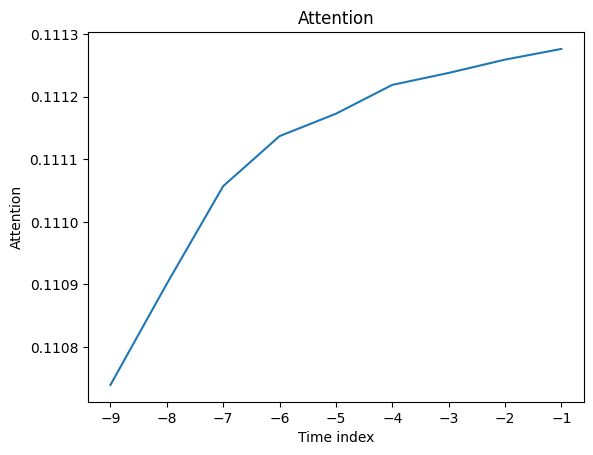

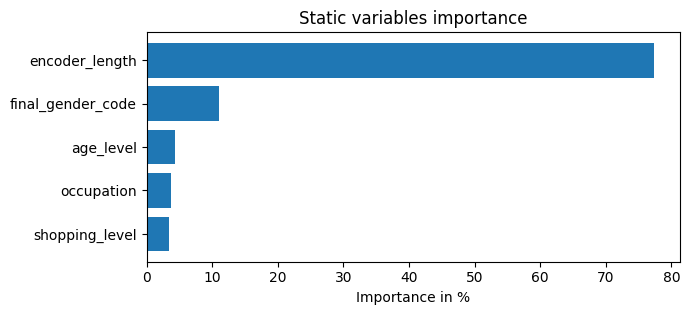

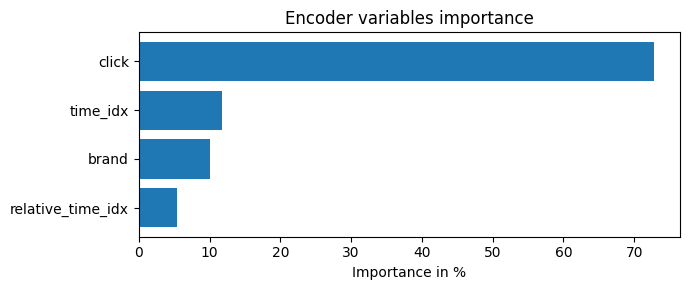

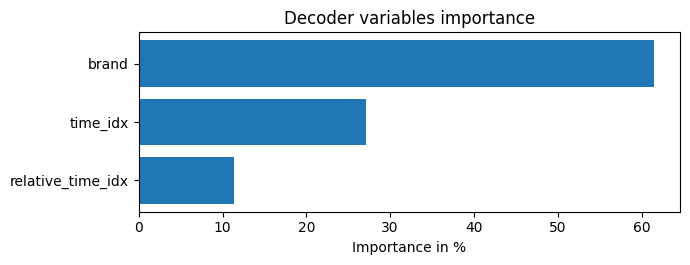

In [1040]:
raw_predictions = tft.predict(val_dataloader, return_x=True,mode='raw')
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [ ]:
interpretation

In [1041]:
def get_tsds(df):
    return TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 9],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=0,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=9,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level","final_gender_code","shopping_level","occupation"],
    #static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    allow_missing_timesteps=True,
    predict_mode=True
)

In [1047]:
def get_importances(user=7):
    importances = {}
    user_df = df_test[df_test['user']==user].reset_index()
    #print(len(user_df))
    tsds = get_tsds(user_df)
    ref = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()[1]
    feature_values_list = []
    values_list = []
    #print(f"Mit allen Datenpunkten ist die Prediction: {referenz}")
    # Letzte weglassen 0 -> -1 macht den größten Unterschied, ist immer der selbe Wert(?)
    for i in range(len(user_df)-2,0,-1):
        brand = user_df.iloc[i]['brand']
        user_df = user_df.drop(i)
        #print(user_df)
        tsds = get_tsds(user_df)
        pred = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()[1]
        #diff = round((referenz-pred).item(),8)
        diff = np.sum(np.abs(ref-pred))
        print(f"Lasse {brand} weg und erhalte als Prediction {pred}, das sind {diff} Differenz")

        feature_values_list.append(brand)
        values_list.append(diff)
        
        importances[brand] = diff
    return feature_values_list,values_list

In [1049]:
df_test.user.unique()[:5]

array([ 7, 37, 62, 67, 89])

In [1050]:
brands,importances = get_importances(user = 37)
importances = importances/np.sum(importances)
ranks = []
for b in brands:
    r = int(click_counts_relative.rank(ascending=False)[b])
    ranks.append(r)
importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
importances_df.sort_values(by="importance")

Lasse 422551 weg und erhalte als Prediction 0.0004648200992960483, das sind 1.8622667994350195e-06 Differenz
Lasse 353787 weg und erhalte als Prediction 0.00046633079182356596, das sind 3.372959326952696e-06 Differenz
Lasse 431329 weg und erhalte als Prediction 0.00046688728616572917, das sind 3.929453669115901e-06 Differenz
Lasse 252916 weg und erhalte als Prediction 0.0004668102483265102, das sind 3.852415829896927e-06 Differenz
Lasse 252916 weg und erhalte als Prediction 0.00046605063835158944, das sind 3.0928058549761772e-06 Differenz
Lasse 431329 weg und erhalte als Prediction 0.00046374864177778363, das sind 7.908092811703682e-07 Differenz
Lasse 349275 weg und erhalte als Prediction 0.0004616905644070357, das sind 1.2672680895775557e-06 Differenz
Lasse 252916 weg und erhalte als Prediction 0.0004607216105796397, das sind 2.236221916973591e-06 Differenz


,brand,importance,rank
5,431329,0.038757,30
6,349275,0.062108,200
0,422551,0.091269,48
7,252916,0.109596,267
4,252916,0.151577,267
1,353787,0.165307,245
3,252916,0.188805,267
2,431329,0.192581,30


In [ ]:
user_df = df[df['user']==7].reset_index()
user_df

In [ ]:
user_df[:5]

In [ ]:
interpretation = tft.interpret_output(tft.predict(get_tsds(user_df), mode="raw", return_x=False).output, reduction="sum")
tft.plot_interpretation(interpretation)

In [ ]:
tft.

In [ ]:
tft.predict(get_tsds(user_df), mode="raw", return_x=False)

In [ ]:
tft.predict(get_tsds(user_df[:5]), mode="raw", return_x=False)

In [ ]:
brands,importances = get_importances(user = 37)
importances = importances/np.sum(importances)
ranks = []
for b in brands:
    r = int(click_counts_relative.rank(ascending=False)[b])
    ranks.append(r)
importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
importances_df.sort_values(by="importance")

In [ ]:
brands,importances = get_importances(user = 62)
importances = importances/np.sum(importances)
ranks = []
for b in brands:
    r = int(click_counts_relative.rank(ascending=False)[b])
    ranks.append(r)
importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
importances_df.sort_values(by="importance")

In [ ]:
brands,importances = get_importances(user = 1004)
importances = importances/np.sum(importances)
ranks = []
for b in brands:
    r = int(click_counts_relative.rank(ascending=False)[b])
    ranks.append(r)
importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
importances_df.sort_values(by="importance")

## Correlation 

Wir verwenden Kendall's Tau um die Korrelation zwischen dem relative click rank und den berechneten importances zu erhalten. 

In [1078]:
df_test[df_test['user']==7].drop(columns='time_stamp')

,user,click,brand,final_gender_code,age_level,shopping_level,occupation,time_idx
0,7,0,402360,1,2,3,0,0
1,7,0,429159,1,2,3,0,1
2,7,0,402360,1,2,3,0,2
3,7,0,252916,1,2,3,0,3
4,7,0,429159,1,2,3,0,4
5,7,0,95766,1,2,3,0,5
6,7,0,95766,1,2,3,0,6
7,7,0,402360,1,2,3,0,7
8,7,0,212912,1,2,3,0,8
9,7,0,402360,1,2,3,0,9


In [892]:
brands,importances = get_importances(user = 7)
importances = importances/np.sum(importances)
ranks = []
for b in brands:
    r = int(click_counts_relative.rank(ascending=False)[b])
    ranks.append(r)
importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
sorted_df = importances_df.sort_values(by="importance")
sorted_df

,brand,importance,rank
5,252916,0.012247,267
6,402360,0.028503,6
7,429159,0.125737,412
3,95766,0.153284,227
4,429159,0.160168,412
2,95766,0.168852,227
1,402360,0.172404,6
0,212912,0.178806,112


In [1080]:
sorted_df.reset_index().drop(columns='index',index=[0,2])

,brand,importance,rank
1,255820,0.085021,145
3,97000,0.164930,218
4,166215,0.164931,187
5,6804,0.164938,287
6,431329,0.164939,30
7,346544,0.170034,84


In [893]:
tau, p_value = kendalltau(sorted_df['importance'], sorted_df['rank'])
tau

-0.264575131106459

In [906]:
import time

In [1051]:
start = time.time()
kendall_results = {}
for user in df_test.user.unique()[:100]:
    brands,importances = get_importances(user = user)
    importances = importances/np.sum(importances)
    ranks = []
    for b in brands:
        r = int(click_counts_relative.rank(ascending=False)[b])
        ranks.append(r)
    importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
    sorted_df = importances_df.sort_values(by="importance")
    tau, p_value = kendalltau(sorted_df['importance'], sorted_df['rank'])
    
    kendall_results[user] = {
        'tau' : tau,
        'p_value' : p_value
    }
end = time.time()
print(f"{end-start} s")

Lasse 212912 weg und erhalte als Prediction 0.043457336723804474, das sind 0.04320744797587395 Differenz
Lasse 402360 weg und erhalte als Prediction 0.04345047473907471, das sind 0.04320058599114418 Differenz
Lasse 95766 weg und erhalte als Prediction 0.043447211384773254, das sind 0.04319732263684273 Differenz
Lasse 95766 weg und erhalte als Prediction 0.043447788804769516, das sind 0.04319790005683899 Differenz
Lasse 429159 weg und erhalte als Prediction 0.04345176741480827, das sind 0.04320187866687775 Differenz
Lasse 252916 weg und erhalte als Prediction 0.00046386715257540345, das sind 0.00021397744421847165 Differenz
Lasse 402360 weg und erhalte als Prediction 0.0004618673410732299, das sind 0.0002119776327162981 Differenz
Lasse 429159 weg und erhalte als Prediction 0.0004605975409504026, das sind 0.0002107078325934708 Differenz
Lasse 422551 weg und erhalte als Prediction 0.0004648200992960483, das sind 1.8622667994350195e-06 Differenz
Lasse 353787 weg und erhalte als Prediction 

Lasse 154597 weg und erhalte als Prediction 0.04345991089940071, das sind 5.766749382019043e-06 Differenz
Lasse 154597 weg und erhalte als Prediction 0.0004618657985702157, das sind 0.043003812432289124 Differenz
Lasse 287015 weg und erhalte als Prediction 0.0004607216105796397, das sind 0.04300495609641075 Differenz
Lasse 285345 weg und erhalte als Prediction 0.0002502950665075332, das sind 4.184548743069172e-07 Differenz
Lasse 108552 weg und erhalte als Prediction 0.04345042631030083, das sind 0.043200548738241196 Differenz
Lasse 374458 weg und erhalte als Prediction 0.043447136878967285, das sind 0.043197259306907654 Differenz
Lasse 89602 weg und erhalte als Prediction 0.04344737529754639, das sind 0.043197497725486755 Differenz
Lasse 89602 weg und erhalte als Prediction 0.04345150664448738, das sind 0.04320162907242775 Differenz
Lasse 374458 weg und erhalte als Prediction 0.04345959052443504, das sind 0.04320971295237541 Differenz
Lasse 86675 weg und erhalte als Prediction 0.043472

Lasse 396367 weg und erhalte als Prediction 0.0002508416655473411, das sind 0.000869888870511204 Differenz
Lasse 205759 weg und erhalte als Prediction 0.0002508127363398671, das sind 0.000869917799718678 Differenz
Lasse 396367 weg und erhalte als Prediction 0.0002505673037376255, das sind 0.0008701632032170892 Differenz
Lasse 396367 weg und erhalte als Prediction 0.0002503253926988691, das sind 0.0008704051142558455 Differenz
Lasse 255820 weg und erhalte als Prediction 0.043473292142152786, das sind 0.04235256090760231 Differenz
Lasse 396367 weg und erhalte als Prediction 0.043494176119565964, das sind 0.04237344488501549 Differenz
Lasse 439634 weg und erhalte als Prediction 0.00025032326811924577, das sind 1.6298145055770874e-07 Differenz
Lasse 441872 weg und erhalte als Prediction 0.00025092970463447273, das sind 7.694179657846689e-07 Differenz
Lasse 439634 weg und erhalte als Prediction 0.0002508610486984253, das sind 7.007620297372341e-07 Differenz
Lasse 441872 weg und erhalte als 

Lasse 274386 weg und erhalte als Prediction 0.029055513441562653, das sind 8.264556527137756e-06 Differenz
Lasse 414896 weg und erhalte als Prediction 0.029044752940535545, das sind 1.9025057554244995e-05 Differenz
Lasse 68998 weg und erhalte als Prediction 0.029039986431598663, das sind 2.3791566491127014e-05 Differenz
Lasse 224985 weg und erhalte als Prediction 0.0011135300155729055, das sind 0.02795024774968624 Differenz
Lasse 108406 weg und erhalte als Prediction 0.0002505792072042823, das sind 0.0288131982088089 Differenz
Lasse 199779 weg und erhalte als Prediction 0.04346000775694847, das sind 0.01439622975885868 Differenz
Lasse 64630 weg und erhalte als Prediction 0.04347287490963936, das sind 0.014409096911549568 Differenz
Lasse 274386 weg und erhalte als Prediction 0.04349400848150253, das sind 0.014430230483412743 Differenz
Lasse 354169 weg und erhalte als Prediction 0.029055485501885414, das sind 0.02341611497104168 Differenz
Lasse 95840 weg und erhalte als Prediction 0.0290

Lasse 154597 weg und erhalte als Prediction 0.0004616905644070357, das sind 0.04300357773900032 Differenz
Lasse 39238 weg und erhalte als Prediction 0.0004607216105796397, das sind 0.04300454631447792 Differenz
Lasse 39238 weg und erhalte als Prediction 0.00046464111073873937, das sind 1.927459379658103e-06 Differenz
Lasse 192996 weg und erhalte als Prediction 0.0004661695274990052, das sind 3.45587613992393e-06 Differenz
Lasse 192996 weg und erhalte als Prediction 0.00046706083230674267, das sind 4.3471809476614e-06 Differenz
Lasse 192996 weg und erhalte als Prediction 0.00046681403182446957, das sind 4.100380465388298e-06 Differenz
Lasse 254155 weg und erhalte als Prediction 0.00046589362318627536, das sind 3.1799718271940947e-06 Differenz
Lasse 192996 weg und erhalte als Prediction 0.00046401729923672974, das sind 1.3036478776484728e-06 Differenz
Lasse 192996 weg und erhalte als Prediction 0.0004618673410732299, das sind 8.463102858513594e-07 Differenz
Lasse 254155 weg und erhalte a

Lasse 34735 weg und erhalte als Prediction 0.04345177859067917, das sind 0.00902225449681282 Differenz
Lasse 255820 weg und erhalte als Prediction 0.0004640190745703876, das sind 0.05201001465320587 Differenz
Lasse 445005 weg und erhalte als Prediction 0.0004617205122485757, das sind 0.05201231315732002 Differenz
Lasse 34735 weg und erhalte als Prediction 0.0004605606955010444, das sind 0.052013471722602844 Differenz
Lasse 424072 weg und erhalte als Prediction 0.02905307710170746, das sind 9.598210453987122e-06 Differenz
Lasse 262734 weg und erhalte als Prediction 0.0011149250203743577, das sind 0.027947749942541122 Differenz
Lasse 97759 weg und erhalte als Prediction 0.0011136311804875731, das sind 0.027949044480919838 Differenz
Lasse 97759 weg und erhalte als Prediction 0.001113735605031252, das sind 0.02794894017279148 Differenz
Lasse 97759 weg und erhalte als Prediction 0.0011151236249133945, das sind 0.027947552502155304 Differenz
Lasse 424072 weg und erhalte als Prediction 0.0002

Lasse 255820 weg und erhalte als Prediction 0.04345081001520157, das sind 0.04320065677165985 Differenz
Lasse 424034 weg und erhalte als Prediction 0.04344742000102997, das sind 0.04319726675748825 Differenz
Lasse 252916 weg und erhalte als Prediction 0.04344771057367325, das sind 0.04319755733013153 Differenz
Lasse 252916 weg und erhalte als Prediction 0.04345177859067917, das sind 0.04320162534713745 Differenz
Lasse 252916 weg und erhalte als Prediction 0.04345991089940071, das sind 0.043209757655858994 Differenz
Lasse 252916 weg und erhalte als Prediction 0.043472882360219955, das sind 0.04322272911667824 Differenz
Lasse 252916 weg und erhalte als Prediction 0.043494176119565964, das sind 0.043244022876024246 Differenz
Lasse 146559 weg und erhalte als Prediction 0.0434575192630291, das sind 8.545815944671631e-06 Differenz
Lasse 146559 weg und erhalte als Prediction 0.04345065355300903, das sind 1.541152596473694e-05 Differenz
Lasse 144517 weg und erhalte als Prediction 0.04344790428

Lasse 95766 weg und erhalte als Prediction 0.0004617205122485757, das sind 1.2230011634528637e-06 Differenz
Lasse 353787 weg und erhalte als Prediction 0.0004605975409504026, das sind 2.3459724616259336e-06 Differenz
Lasse 353787 weg und erhalte als Prediction 0.00025029745302163064, das sind 3.891764208674431e-07 Differenz
Lasse 13036 weg und erhalte als Prediction 0.0002506353775970638, das sind 7.271009963005781e-07 Differenz
Lasse 353787 weg und erhalte als Prediction 0.0002511262136977166, das sind 1.217937096953392e-06 Differenz
Lasse 98931 weg und erhalte als Prediction 0.0002508253965061158, das sind 9.171199053525925e-07 Differenz
Lasse 13036 weg und erhalte als Prediction 0.04345177859067917, das sind 0.04320187121629715 Differenz
Lasse 207800 weg und erhalte als Prediction 0.00046401884173974395, das sind 0.00021411056513898075 Differenz
Lasse 98931 weg und erhalte als Prediction 0.0004618657985702157, das sind 0.0002119575219694525 Differenz
Lasse 98931 weg und erhalte als 

Lasse 98931 weg und erhalte als Prediction 0.04344763979315758, das sind 1.835450530052185e-05 Differenz
Lasse 13036 weg und erhalte als Prediction 0.0004657377430703491, das sind 0.04300025478005409 Differenz
Lasse 98931 weg und erhalte als Prediction 0.0004638651735149324, das sind 0.04300212860107422 Differenz
Lasse 98931 weg und erhalte als Prediction 0.0004617205122485757, das sind 0.04300427436828613 Differenz
Lasse 98931 weg und erhalte als Prediction 0.0004605975409504026, das sind 0.04300539568066597 Differenz
Lasse 143597 weg und erhalte als Prediction 0.0011171875521540642, das sind 3.3135293051600456e-06 Differenz
Lasse 143597 weg und erhalte als Prediction 0.0011147212935611606, das sind 5.77978789806366e-06 Differenz
Lasse 143597 weg und erhalte als Prediction 0.00025112670846283436, das sind 0.0008693743729963899 Differenz
Lasse 31950 weg und erhalte als Prediction 0.00025101035134866834, das sind 0.0008694907301105559 Differenz
Lasse 252916 weg und erhalte als Predictio

Lasse 78410 weg und erhalte als Prediction 0.00025031823315657675, das sind 3.7180143408477306e-07 Differenz
Lasse 207800 weg und erhalte als Prediction 0.0002509024634491652, das sind 9.560317266732454e-07 Differenz
Lasse 346544 weg und erhalte als Prediction 0.00025084931985475123, das sind 9.028881322592497e-07 Differenz
Lasse 73218 weg und erhalte als Prediction 0.0002510101185180247, das sind 1.0636867955327034e-06 Differenz
Lasse 16008 weg und erhalte als Prediction 0.04345150664448738, das sind 0.04320156201720238 Differenz
Lasse 252916 weg und erhalte als Prediction 0.04345959052443504, das sind 0.04320964589715004 Differenz
Lasse 364892 weg und erhalte als Prediction 0.04347286373376846, das sind 0.04322291910648346 Differenz
Lasse 143597 weg und erhalte als Prediction 0.0004607216105796397, das sind 0.0002107751788571477 Differenz
Lasse 353787 weg und erhalte als Prediction 0.00046434227260760963, das sind 1.5744008123874664e-06 Differenz
Lasse 411138 weg und erhalte als Pred

Lasse 127319 weg und erhalte als Prediction 0.00025032515986822546, das sind 0.0522216372191906 Differenz
Lasse 422876 weg und erhalte als Prediction 0.00024959779693745077, das sind 0.0522223636507988 Differenz
Lasse 163935 weg und erhalte als Prediction 0.043494176119565964, das sind 0.00897778570652008 Differenz
Lasse 252916 weg und erhalte als Prediction 0.043456900864839554, das sind 9.123235940933228e-06 Differenz
Lasse 62656 weg und erhalte als Prediction 0.04345114529132843, das sind 1.4878809452056885e-05 Differenz
Lasse 252916 weg und erhalte als Prediction 0.04344739392399788, das sind 1.8630176782608032e-05 Differenz
Lasse 62656 weg und erhalte als Prediction 0.04344775900244713, das sind 1.8265098333358765e-05 Differenz
Lasse 95766 weg und erhalte als Prediction 0.04345220327377319, das sind 1.3820827007293701e-05 Differenz
Lasse 252916 weg und erhalte als Prediction 0.04346032813191414, das sind 5.695968866348267e-06 Differenz
Lasse 252916 weg und erhalte als Prediction 0

In [1059]:
kendall_df = pd.DataFrame().from_dict(kendall_results,orient='index')
kendall_df

,tau,p_value
7,-0.188982,0.526537
37,0.231455,0.441105
62,0.161165,0.595163
67,0.357143,0.275099
89,-0.089087,0.774349
...,...,...
4286,-0.444750,0.131587
4322,-0.370625,0.208912
4453,-0.453632,0.140392
4500,0.113389,0.702440


In [1073]:
df_test[df_test['user']==7].drop(columns="time_stamp")

,user,click,brand,final_gender_code,age_level,shopping_level,occupation,time_idx
0,7,0,402360,1,2,3,0,0
1,7,0,429159,1,2,3,0,1
2,7,0,402360,1,2,3,0,2
3,7,0,252916,1,2,3,0,3
4,7,0,429159,1,2,3,0,4
5,7,0,95766,1,2,3,0,5
6,7,0,95766,1,2,3,0,6
7,7,0,402360,1,2,3,0,7
8,7,0,212912,1,2,3,0,8
9,7,0,402360,1,2,3,0,9


In [1081]:
kendall_df.tau.describe()

count    100.000000
mean       0.028766
std        0.311059
min       -0.642540
25%       -0.218218
50%        0.075638
75%        0.237238
max        0.617213
Name: tau, dtype: float64

In [1061]:
kendall_df.p_value.describe()

count    100.000000
mean       0.459989
std        0.282684
min        0.030401
25%        0.209009
50%        0.450887
75%        0.668001
max        1.000000
Name: p_value, dtype: float64

In [1052]:
kendall_results

{7: {'tau': -0.1889822365046136, 'p_value': 0.5265374292133732},
 37: {'tau': 0.23145502494313788, 'p_value': 0.44110482535611073},
 62: {'tau': 0.16116459280507603, 'p_value': 0.5951631467095725},
 67: {'tau': 0.3571428571428571, 'p_value': 0.27509920634920637},
 89: {'tau': -0.0890870806374748, 'p_value': 0.7743488608474193},
 196: {'tau': -0.25458753860865774, 'p_value': 0.38281014365989596},
 332: {'tau': 0.12371791482634839, 'p_value': 0.687617537030896},
 344: {'tau': 0.3571428571428571, 'p_value': 0.27509920634920637},
 348: {'tau': 0.1889822365046136, 'p_value': 0.5243108008991832},
 496: {'tau': 0.13006649542861798, 'p_value': 0.6802795473344503},
 498: {'tau': 0.14824986333222023, 'p_value': 0.6152281670802446},
 544: {'tau': 0.0, 'p_value': 1.0},
 731: {'tau': 0.5669467095138409, 'p_value': 0.05611472402809984},
 817: {'tau': 0.3857583749052298, 'p_value': 0.1991834291115624},
 830: {'tau': 0.6172133998483676, 'p_value': 0.03995533574046058},
 927: {'tau': -0.288675134594812

# Beobachtungen

- Leider keine statistische Evidenz 
- TFT füllt auf, wenn man sich tft.predict(tsds, mode="raw", return_x=False) betrachtet, ist encoder length trotzdem immer gleich lang

# Backlog

In [462]:
#users zum testen: 7, 37, 62
brands,importances = get_importances(user = 7)
importances = importances/np.sum(importances)
print("*"*32)
for b,i in zip(brands,importances):
    print(f"Brand: {b} -> Importance: {i}")

********************************
Brand: 212912 -> Importance: 0.12300637364387512
Brand: 402360 -> Importance: 0.121696338057518
Brand: 95766 -> Importance: 0.12092511355876923
Brand: 95766 -> Importance: 0.12094711512327194
Brand: 429159 -> Importance: 0.12200260907411575
Brand: 252916 -> Importance: 0.12680822610855103
Brand: 402360 -> Importance: 0.1293419748544693
Brand: 429159 -> Importance: 0.13527220487594604


In [437]:
#users zum testen: 7, 37, 62
brands,importances = get_importances(user = 37)
importances = importances/np.sum(importances)
print("*"*32)
for b,i in zip(brands,importances):
    print(f"Brand: {b} -> Importance: {i}")

10
Mit allen Datenpunkten ist die Prediction: [0.9669952  0.03300475]
Lasse 422551 weg und erhalte als Prediction [0.96708673 0.03291324], das sind 0.011475011706352234 Differenz
Lasse 353787 weg und erhalte als Prediction [0.96714807 0.03285189], das sind 0.011352330446243286 Differenz
Lasse 431329 weg und erhalte als Prediction [0.9671689  0.03283103], das sind 0.011310610920190811 Differenz
Lasse 252916 weg und erhalte als Prediction [0.96716666 0.03283329], das sind 0.011315137147903442 Differenz
Lasse 252916 weg und erhalte als Prediction [0.96714026 0.03285974], das sind 0.01136799156665802 Differenz
Lasse 431329 weg und erhalte als Prediction [0.9670496  0.03295038], das sind 0.011549286544322968 Differenz
Lasse 349275 weg und erhalte als Prediction [0.9669138  0.03308613], das sind 0.01182081550359726 Differenz
Lasse 252916 weg und erhalte als Prediction [0.9666843  0.03331565], das sind 0.012279871851205826 Differenz
********************************
Brand: 422551 -> Importance

In [ ]:
for b,i in zip(brands,importances):

In [ ]:
click_counts = df.groupby('brand')['click'].sum().sort_values(ascending=False)

In [440]:
brands,importances = get_importances(user = 62)
importances = importances/np.sum(importances)
ranks = []
for b in brands:
    r = int(click_counts.rank(ascending=False)[b])
    ranks.append(r)
importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
importances_df.sort_values(by="rank")

10
Mit allen Datenpunkten ist die Prediction: [0.9671437  0.03285626]
Lasse 255820 weg und erhalte als Prediction [0.9671873  0.03281269], das sind 0.011273909360170364 Differenz
Lasse 255820 weg und erhalte als Prediction [0.9672203  0.03277972], das sind 0.011207923293113708 Differenz
Lasse 255820 weg und erhalte als Prediction [0.9672427  0.03275729], das sind 0.011163074523210526 Differenz
Lasse 424072 weg und erhalte als Prediction [0.96723145 0.03276849], das sind 0.01118554174900055 Differenz
Lasse 255820 weg und erhalte als Prediction [0.96710414 0.0328959 ], das sind 0.01144026592373848 Differenz
Lasse 327439 weg und erhalte als Prediction [0.9670301 0.0329699], das sind 0.01158829778432846 Differenz
Lasse 269352 weg und erhalte als Prediction [0.9671551  0.03284486], das sind 0.011338267475366592 Differenz
Lasse 39455 weg und erhalte als Prediction [0.9667367  0.03326334], das sind 0.012175176292657852 Differenz


In [453]:
importances_df = pd.DataFrame({"brand":brands,"importance":importances,"rank":ranks})
importances_df.sort_values(by="rank")

,brand,importance,rank
6,269352,0.124088,4
0,255820,0.123384,6
1,255820,0.122662,6
2,255820,0.122171,6
4,255820,0.125205,6
5,327439,0.126825,8
3,424072,0.122417,37
7,39455,0.133248,51


In [439]:
#users zum testen: 7, 37, 62
brands,importances = get_importances(user = 62)
importances = importances/np.sum(importances)
print("*"*32)
for b,i in zip(brands,importances):
    rank_number = int(click_counts.rank(ascending=False)[b])

    print(f"Brand: {b} -> Importance: {i}; Rank: {rank_number}")

10
Mit allen Datenpunkten ist die Prediction: [0.9671437  0.03285626]
Lasse 255820 weg und erhalte als Prediction [0.9671873  0.03281269], das sind 0.011273909360170364 Differenz
Lasse 255820 weg und erhalte als Prediction [0.9672203  0.03277972], das sind 0.011207923293113708 Differenz
Lasse 255820 weg und erhalte als Prediction [0.9672427  0.03275729], das sind 0.011163074523210526 Differenz
Lasse 424072 weg und erhalte als Prediction [0.96723145 0.03276849], das sind 0.01118554174900055 Differenz
Lasse 255820 weg und erhalte als Prediction [0.96710414 0.0328959 ], das sind 0.01144026592373848 Differenz
Lasse 327439 weg und erhalte als Prediction [0.9670301 0.0329699], das sind 0.01158829778432846 Differenz
Lasse 269352 weg und erhalte als Prediction [0.9671551  0.03284486], das sind 0.011338267475366592 Differenz
Lasse 39455 weg und erhalte als Prediction [0.9667367  0.03326334], das sind 0.012175176292657852 Differenz
********************************


AttributeError: 'numpy.float64' object has no attribute 'as_type'

Es wird die absolute Differenz in den prädizierten Klassen aufsummiert.  
Wenn eine Brand hier mehr important als die andere ist, heißt das, dass sie ein besserer Diskriminator ist.  

**Kann das statistisch so bestätigt werden? Haben diese Brands entweder viele oder keine Klicks?**. 

In [412]:
click_counts = df.groupby('brand')['click'].sum().sort_values(ascending=False)
click_counts

brand
353787    873
143597    657
95766     391
269352    342
98931     340
         ... 
424479      1
307747      1
402903      0
295595      0
76952       0
Name: click, Length: 488, dtype: int64

In [420]:
rank_number = click_counts.rank(ascending=False)['95766']
rank_number

3.0

In [410]:
'39455' in brand_ranking

True

In [395]:
df.groupby("brand")

TypeError: Must provide 'func' or tuples of '(column, aggfunc).

In [389]:
#TODO:
#Finde raus, wie wichtig ist die Spalte Brand, rechne dann prozentual runter

In [343]:
user_df = df[df['user']==37].reset_index()
tsds = get_tsds(user_df)
ref = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()
print(ref)
user_df

[0.9728242  0.02717571]


,index,user,time_stamp,click,brand,final_gender_code,age_level,shopping_level,occupation,time_idx
0,10,37,2017-05-06 03:26:06,0,243025,2,2,3,0,0
1,11,37,2017-05-06 05:00:23,0,252916,2,2,3,0,1
2,12,37,2017-05-06 07:06:23,0,349275,2,2,3,0,2
3,13,37,2017-05-08 12:40:58,0,431329,2,2,3,0,3
4,14,37,2017-05-09 11:00:01,0,252916,2,2,3,0,4
5,15,37,2017-05-09 11:02:58,0,252916,2,2,3,0,5
6,16,37,2017-05-10 09:38:40,0,431329,2,2,3,0,6
7,17,37,2017-05-11 12:33:30,0,353787,2,2,3,0,7
8,18,37,2017-05-11 23:33:07,0,422551,2,2,3,0,8
9,19,37,2017-05-11 23:33:07,0,143464,2,2,3,0,9


In [344]:
tft.predict(tsds, mode="raw", return_x=False)

Output(prediction=tensor([[[ 1.7864, -1.7915]]]), encoder_attention=tensor([[[[0.1183, 0.1272, 0.0874, 0.1034, 0.1300, 0.1088, 0.0760, 0.1228,
           0.1261]]]]), decoder_attention=tensor([[[[0.]]]]), static_variables=tensor([[[0.2903, 0.1385, 0.0314, 0.0895, 0.4503]]]), encoder_variables=tensor([[[[0.1455, 0.6156, 0.2198, 0.0192]],

         [[0.2289, 0.4958, 0.2554, 0.0199]],

         [[0.2496, 0.4854, 0.2447, 0.0203]],

         [[0.2021, 0.5475, 0.2309, 0.0195]],

         [[0.2328, 0.4803, 0.2669, 0.0199]],

         [[0.2340, 0.4745, 0.2716, 0.0200]],

         [[0.1975, 0.5346, 0.2484, 0.0194]],

         [[0.0530, 0.5963, 0.3149, 0.0358]],

         [[0.0417, 0.6460, 0.2606, 0.0518]]]]), decoder_variables=tensor([[[[0.2610, 0.0491, 0.6899]]]]), decoder_lengths=tensor([1]), encoder_lengths=tensor([9]))

In [339]:
user_df = df[df['user']==37].reset_index()
user_df = user_df.drop([1,2,3,4,5,6,7,8])
tsds = get_tsds(user_df)
pred = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()
print(pred)
user_df

[0.9728108  0.02718921]


,index,user,time_stamp,click,brand,final_gender_code,age_level,shopping_level,occupation,time_idx
0,10,37,2017-05-06 03:26:06,0,243025,2,2,3,0,0
9,19,37,2017-05-11 23:33:07,0,143464,2,2,3,0,9


In [340]:
tft.predict(tsds, mode="raw", return_x=False)

Output(prediction=tensor([[[ 1.7849, -1.7925]]]), encoder_attention=tensor([[[[0.1206, 0.1186, 0.1174, 0.1230, 0.1118, 0.1034, 0.1012, 0.1015,
           0.1025]]]]), decoder_attention=tensor([[[[0.]]]]), static_variables=tensor([[[0.2903, 0.1385, 0.0314, 0.0895, 0.4503]]]), encoder_variables=tensor([[[[0.1427, 0.6056, 0.2325, 0.0193]],

         [[0.1398, 0.6084, 0.2325, 0.0193]],

         [[0.1367, 0.6113, 0.2327, 0.0193]],

         [[0.1332, 0.6144, 0.2330, 0.0194]],

         [[0.1293, 0.6179, 0.2333, 0.0195]],

         [[0.1250, 0.6219, 0.2336, 0.0196]],

         [[0.1202, 0.6265, 0.2336, 0.0197]],

         [[0.1150, 0.6312, 0.2339, 0.0199]],

         [[0.1095, 0.6349, 0.2354, 0.0201]]]]), decoder_variables=tensor([[[[0.2618, 0.0492, 0.6890]]]]), decoder_lengths=tensor([1]), encoder_lengths=tensor([9]))

**Problem**: Es wird auf einmal nur noch 0 prädiziert vom tft

In [233]:
predictions = tft.predict(val_dataloader)
predictions.sum()

tensor(0)

In [257]:
data = df[df['user']==37].reset_index()
data

,index,user,time_stamp,click,brand,final_gender_code,age_level,shopping_level,occupation,time_idx
0,10,37,2017-05-06 03:26:06,0,243025,2,2,3,0,0
1,11,37,2017-05-06 05:00:23,0,252916,2,2,3,0,1
2,12,37,2017-05-06 07:06:23,0,349275,2,2,3,0,2
3,13,37,2017-05-08 12:40:58,0,431329,2,2,3,0,3
4,14,37,2017-05-09 11:00:01,0,252916,2,2,3,0,4
5,15,37,2017-05-09 11:02:58,0,252916,2,2,3,0,5
6,16,37,2017-05-10 09:38:40,0,431329,2,2,3,0,6
7,17,37,2017-05-11 12:33:30,0,353787,2,2,3,0,7
8,18,37,2017-05-11 23:33:07,0,422551,2,2,3,0,8
9,19,37,2017-05-11 23:33:07,0,143464,2,2,3,0,9


In [260]:
from torch.nn import Softmax

In [263]:
tsds = get_tsds(data)
probabilities = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()[0]
probabilities

0.9728242

In [244]:
data.groupby(['user', 'age_level'])['brand'].agg(list).reset_index().values

array([[37, '2',
        list(['243025', '252916', '349275', '431329', '252916', '252916', '431329', '353787', '422551', '143464'])]],
      dtype=object)

In [ ]:
tsds = get_tsds(df)
probabilities = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()

In [ ]:
explainer = KernelExplainer(
            self._predict_proba,
            x_transformed
        )

In [238]:
custom_tft = Custom_TFT()

In [239]:
custom_tft.predict_proba()

TypeError: Custom_TFT.predict_proba() missing 1 required positional argument: 'x'